MobileNetV2 model

---

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

# Open file
import os
import PIL
from random import seed
# Model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Create function plot loss function and accuracy score graph
def plot_graph(model_values):
    ''' 
    Input : Model_values of keras.callbacks.History
    Return : Graph of Loss function and accuracy score between training dataset and vaildation dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss');
    plt.plot(model_values.history['val_loss'], label='Testing Loss');
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot MSE
    plt.subplot(1, 2, 2)
    
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

00. Check GPU
   ---

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8227984769728778514
xla_global_id: -1
]


01. Open Datasets
   ---

In [5]:
# set state seed
seed(42)

# Open path file of dataset 
dataset_path_new = "dataset_train_valid_test"

train_dir = os.path.join(dataset_path_new, "train")
valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

02. Preprocessing Image Datasets
   ---

In [6]:
# Set parameter of image 
# https://github.com/keras-team/keras/issues/8090#issuecomment-335155737
batch_size = 50 # Set the batch size for epoch cycle
img_height = 128 # Set the height of the picture
img_width = 128 # Set the width of the picture

# Rescale pixel to reduce image size before using in model
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

In [7]:
# Create training dataset 
train_dataset = data_gen_train.flow_from_directory(train_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)
 

# Create validation dataset 
valid_dataset = data_gen_valid.flow_from_directory(valid_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

# Create testing dataset 
test_dataset = data_gen_test.flow_from_directory(test_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size)

Found 7758 images belonging to 4 classes.
Found 834 images belonging to 4 classes.
Found 813 images belonging to 4 classes.


---

03. MobileNetV2 Model Training
   ---

Transfer Learning

In [8]:
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
# import MobileNetV2 model form keras API
# set input size of image of trianing is 128x128 (smallest size of MobileNetV2)
# due to we want to use transfer learning process 
# we must add `include_top=False` because we wan to add our input data 
# we decide default weigh for mode
mobv2_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                                include_top=False, # Transfer learning
                                                weights="imagenet")

9406464/9406464 [==============================] - 3s 0us/step


In [9]:
# model summary
# Total params: 2,257,984
# Trainable params: 2,223,872
# Non-trainable params: 34,112
mobv2_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [10]:
# fix weights and bias 
# train specifically custom head
mobv2_model.trainable=False

Add custom head and output layers

In [11]:
# Create output layer 
# We have 4 classes in our output we decide using activation="softmax" 
# for multi classification.
# Before output layer we decide use GlobalAveragePooling2D as 
# one type of flatten layer.
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(mobv2_model.output) # flatten
prediction_layer = tf.keras.layers.Dense(units=4, activation="softmax")(average_pooling_layer)

In [12]:
# Add Input layer and output layer 
model = tf.keras.models.Model(inputs=mobv2_model.input, 
                                    outputs=prediction_layer)

In [13]:
# Total params: 2,263,108
# Trainable params: 5,124 # add input layers and  output layers
# Non-trainable params: 2,257,984 --> fix layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [14]:
# Compile the model         
model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [15]:
# Save checkpoints during training
checkpoint_path = "model/mobilenetV2/mobilenetv2_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 mode="max",
                                                 verbose=1,
                                                 monitor="val_accuracy")

In [16]:
# Training model
# make sure you truely save checkpoint_path
history = model.fit(train_dataset,
          epochs=25,
          validation_data=valid_dataset,
          callbacks=[cp_callback])

Epoch 1/25
156/156 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7984
Epoch 1: saving model to model/mobilenetV2/mobilenetv2_cp\cp.ckpt
156/156 [==============================] - 50s 308ms/step - loss: 0.5467 - accuracy: 0.7984 - val_loss: 0.3989 - val_accuracy: 0.8561
Epoch 2/25
156/156 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8966
Epoch 2: saving model to model/mobilenetV2/mobilenetv2_cp\cp.ckpt
156/156 [==============================] - 51s 329ms/step - loss: 0.3005 - accuracy: 0.8966 - val_loss: 0.3279 - val_accuracy: 0.8861
Epoch 3/25
156/156 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.9185
Epoch 3: saving model to model/mobilenetV2/mobilenetv2_cp\cp.ckpt
156/156 [==============================] - 49s 317ms/step - loss: 0.2471 - accuracy: 0.9185 - val_loss: 0.2802 - val_accuracy: 0.9065
Epoch 4/25
156/156 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9281
Epoch 4: saving 

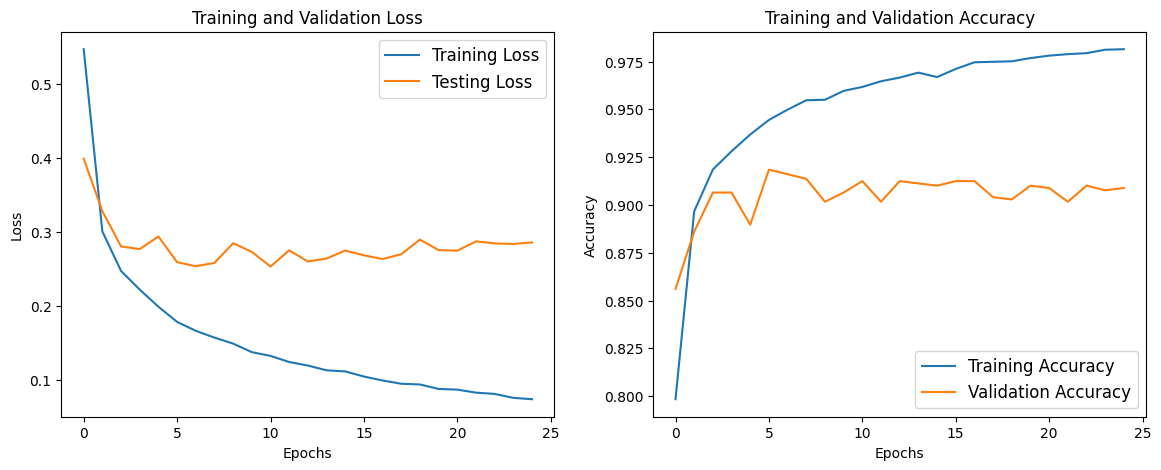

In [17]:
# plot graph 
plot_graph(history)

In [18]:
# convert the history.history dict to a pandas DataFrame:    
hist_df = pd.DataFrame(history.history) 
# save history to csv:  
hist_csv_file = 'model/mobilenetV2/history_mobilenetv2_tf.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [19]:
# save model
model.save("model/mobilenetV2/mobilenetv2.h5")

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

Fine Tuning

---

In [20]:
img_height = 128 # Set the height of the picture
img_width = 128 # Set the width of the picture

# load model
mobv2_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width,3),
                                              include_top=False, # Transfer learning
                                              weights="imagenet",
                                              )  

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobv2_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobv2_model.layers[:fine_tune_at]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(mobv2_model.layers):
    if i >= 95:
        print(i, layer.name, layer.trainable)

# Add input layers and output layers
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(mobv2_model.output) # flatten
prediction_layer = tf.keras.layers.Dense(units=4, activation="softmax")(average_pooling_layer)
fineture_model = tf.keras.models.Model(inputs=mobv2_model.input, 
                                     outputs=prediction_layer)

# Compile the model         
fineture_model.compile(loss="categorical_crossentropy", 
                       optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=['accuracy'])

Number of layers in the base model:  154
95 block_10_depthwise_relu False
96 block_10_project False
97 block_10_project_BN False
98 block_11_expand False
99 block_11_expand_BN False
100 block_11_expand_relu True
101 block_11_depthwise True
102 block_11_depthwise_BN True
103 block_11_depthwise_relu True
104 block_11_project True
105 block_11_project_BN True
106 block_11_add True
107 block_12_expand True
108 block_12_expand_BN True
109 block_12_expand_relu True
110 block_12_depthwise True
111 block_12_depthwise_BN True
112 block_12_depthwise_relu True
113 block_12_project True
114 block_12_project_BN True
115 block_12_add True
116 block_13_expand True
117 block_13_expand_BN True
118 block_13_expand_relu True
119 block_13_pad True
120 block_13_depthwise True
121 block_13_depthwise_BN True
122 block_13_depthwise_relu True
123 block_13_project True
124 block_13_project_BN True
125 block_14_expand True
126 block_14_expand_BN True
127 block_14_expand_relu True
128 block_14_depthwise True
129 

In [21]:
# Save checkpoints during training
# follow value of vaildation scorce 
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/mobilenetV2/mobilenetv2_ft.h5', 
                             monitor= 'val_accuracy', 
                             mode= 'max', 
                             save_best_only = True, 
                             verbose= 1)

In [22]:
# Training model
# make sure you truely save checkpoint_path
history_ft = fineture_model.fit(train_dataset,  
                             epochs=25, 
                             validation_data=valid_dataset, 
                             callbacks=[checkpoint]) # fine tune continue form transfer learning

Epoch 1/25
156/156 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8853
Epoch 1: val_accuracy improved from -inf to 0.50480, saving model to model/mobilenetV2\mobilenetv2_ft.h5
156/156 [==============================] - 63s 381ms/step - loss: 0.3574 - accuracy: 0.8853 - val_loss: 11.4519 - val_accuracy: 0.5048
Epoch 2/25
156/156 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9511
Epoch 2: val_accuracy improved from 0.50480 to 0.52278, saving model to model/mobilenetV2\mobilenetv2_ft.h5
156/156 [==============================] - 57s 364ms/step - loss: 0.1543 - accuracy: 0.9511 - val_loss: 9.1678 - val_accuracy: 0.5228
Epoch 3/25
156/156 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9618
Epoch 3: val_accuracy improved from 0.52278 to 0.55036, saving model to model/mobilenetV2\mobilenetv2_ft.h5
156/156 [==============================] - 82s 526ms/step - loss: 0.1137 - accuracy: 0.9618 - val_loss: 7.8476 - val_accur

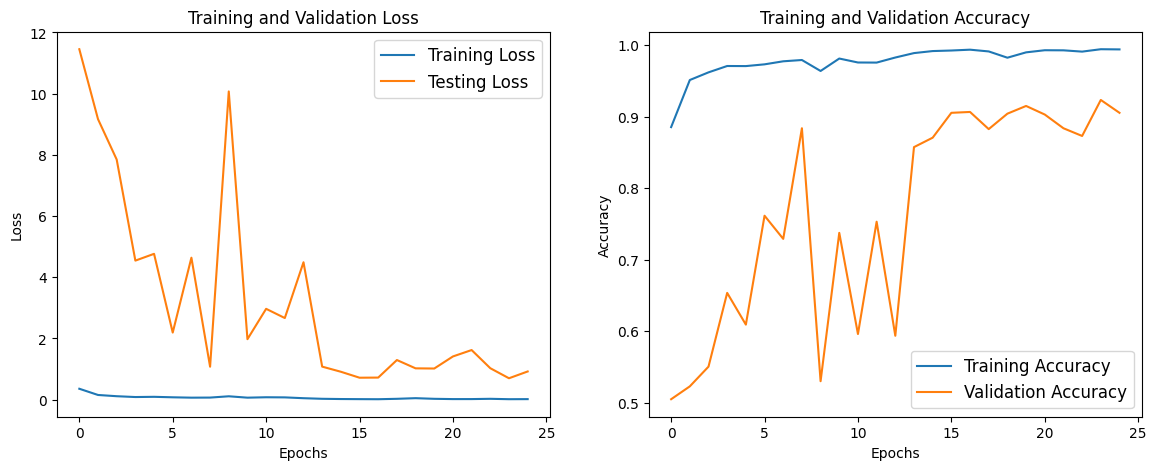

In [23]:
# plot graph 
plot_graph(history_ft)

In [24]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_ft.history) 
hist_df.head()

# save to csv: 
hist_csv_file = 'model/mobilenetV2/history_mobilenetv2_ft.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [25]:
# save model after fine tuning
fineture_model.save("model/mobilenetV2/mobilenetv2_ft.h5")

---